# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
doc(get_transforms)

NameError: name 'doc' is not defined

In [6]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [8]:
data = get_data(224, bs, 'zeros')

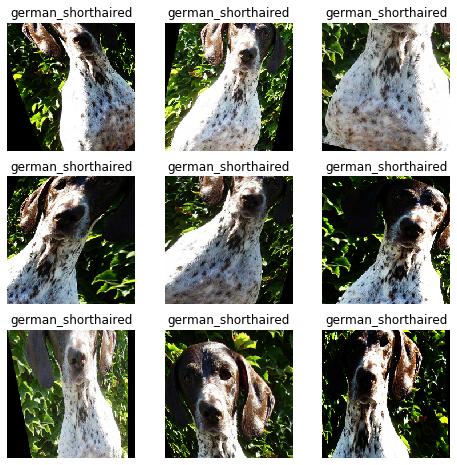

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [10]:
data = get_data(224,bs)

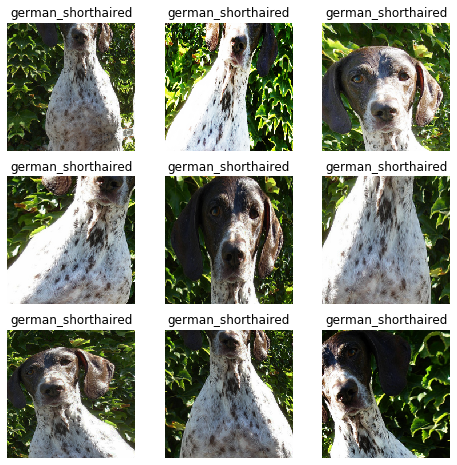

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [12]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [13]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.393587,1.118616,0.240866,00:35
1,1.443264,0.353109,0.082544,00:31
2,0.893060,0.289074,0.074425,00:31


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.708001,0.269306,0.058187,00:29
1,0.666836,0.267181,0.060217,00:29


In [ ]:
data = get_data(352,bs)
learn.data = data

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.633500,0.261447,0.054804,01:08
1,0.595398,0.259402,0.051421,01:06


In [ ]:
learn.save('352')

## Convolution kernel

In [14]:
data = get_data(352,16)

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/.fastai/data/oxford-iiit-pet/images/models/352.pth'

Category newfoundland

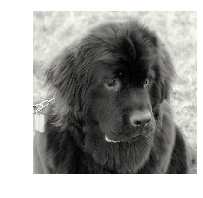

In [ ]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [ ]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [ ]:
k.shape

torch.Size([1, 3, 3, 3])

In [ ]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [ ]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [ ]:
edge = F.conv2d(t[None], k)

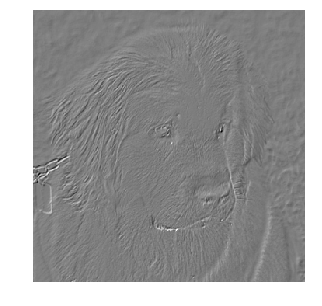

In [ ]:
show_image(edge[0], figsize=(5,5));

In [ ]:
data.c

37

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
______________________________________________________________

## Heatmap

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

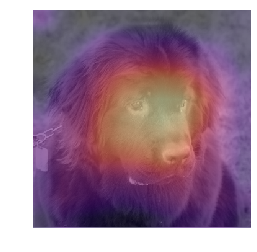

In [ ]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [16]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

NameError: name 'hook_g' is not defined

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

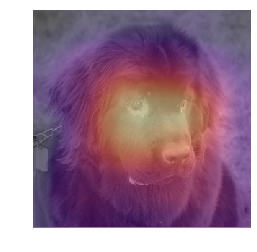

In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

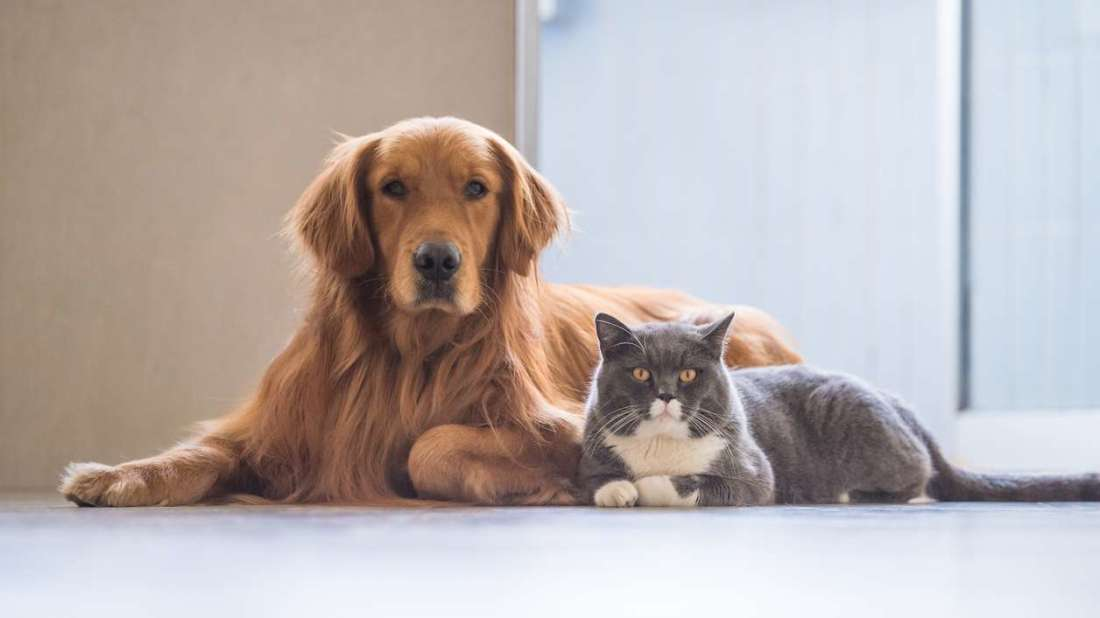

In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

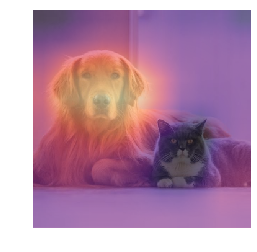

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'Abyssinian'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

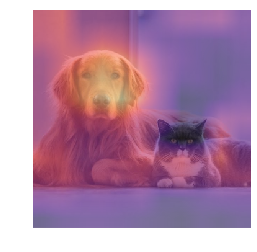

In [ ]:
show_heatmap(mult)

## fin